# Fig: Intro, etc

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from figures.fighelper import *
from analysis.glm import *


# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
pal_model, pal_cat = get_palette()
skip_fits = [
    'fixate2_nf-420_beta-0.15_(2023_04_27,13:57)',
    'fixate1_nf-420_beta-0.8_(2023_05_07,04:15)',
]
kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}

def _info(fit):
    info = fit.split('_')
    i = info.index([
        e for e in info
        if 'nf-' in e
    ].pop())
    category = info[i - 1]
    nf = int(info[i].split('-')[1])
    beta = info[i + 1].split('-')[1]
    try:
        beta = float(beta)
    except ValueError:
        beta = str(beta)
    tag = 'VAE' if 'vanilla' in info else 'cNVAE'
    if beta == 'ae':
        tag = tag.replace('V', '')
    return category, nf, beta, tag

In [3]:
# HIDE CODE


def _do_pca(a):
    a = flatten_arr(a, ndim_end=0, ndim_start=1)
    u, s, v = sp_lin.svd(a, full_matrices=False, compute_uv=True)
    s *= 100 / s.sum()
    titles = [f"{e:0.1f} %" for e in s]
    pcs = v.reshape(-1, of.dim, of.dim, 2)
    return s, pcs, titles


def _plot_singular_values(s, thres=90):
    fig, axes = create_figure(2, 1, (13, 7), sharex='all')
    axes[0].plot(s, marker='.')
    axes[1].plot(np.cumsum(s), lw=3, marker=None)

    idx = np.where(np.cumsum(s) > thres)[0][0]
    axes[1].axvline(
        idx, color='g', ls=':', lw=1.5,
        label=f'{idx} dimensions',
    )
    axes[1].axhline(
        thres, color='magenta', ls=':', lw=1.5,
        label=f'{thres}% of variance',
    )
    axes[1].legend()

    axes[1].axhline(0, color='k', ls='--', lw=1.2)
    axes[1].axhline(100, color='k', ls='--', lw=1.2)
    axes[1].set_ylim((-3, 103))
    add_grid(axes)
    plt.show()


def _sizes_hist(of, obj_i: int = 0):
    fig, ax = create_figure(1, 1, (15, 5))
    size_pix = of.objects[obj_i].size * of.dim ** 2
    sns.histplot(size_pix, bins=np.linspace(0, 100, 101) - 0.5, stat='percent', ax=ax)

    for color, thres in zip(['magenta', 'k', 'r'], [2, 4, 8]):
        lbl = f'{100 * (size_pix < thres).sum() / of.n:0.1f}% smaller than {thres} pixels'
        ax.axvline(thres, color=color, ls='--', lw=1.3, label=lbl)
    ax.legend(fontsize=17)
    plt.show()

In [4]:
kws = dict(
    dim=17,
    fov=45.0,
    obj_r=0.25,
    obj_bound=0.97,
    obj_zlim=(0.5, 1.0),
    vlim_obj=(0.01, 1.0),
    vlim_slf=(0.01, 1.0),
    residual=False,
    z_bg=1.0,
    seed=0,
)
print(kws)

min_obj_size = 3.5

{
    'dim': 17,
    'fov': 45.0,
    'obj_r': 0.25,
    'obj_bound': 0.97,
    'obj_zlim': (0.5, 1.0),
    'vlim_obj': (0.01, 1.0),
    'vlim_slf': (0.01, 1.0),
    'residual': False,
    'z_bg': 1.0,
    'seed': 0
}

## ROFL traversal

In [5]:
from analysis.opticflow import *

In [6]:
%%time

of = ROFL(
    category='fixate',
    n=int(1.23e2),
    n_obj=1,
    **kws,
).compute_coords()
_ = of.compute_flow()
accept = of.filter(min_obj_size)
of.gamma = None

s, pcs, titles = _do_pca(of.alpha_dot[accept])

CPU times: user 384 ms, sys: 53.4 ms, total: 437 ms
Wall time: 127 ms


In [7]:
accept.sum()

110

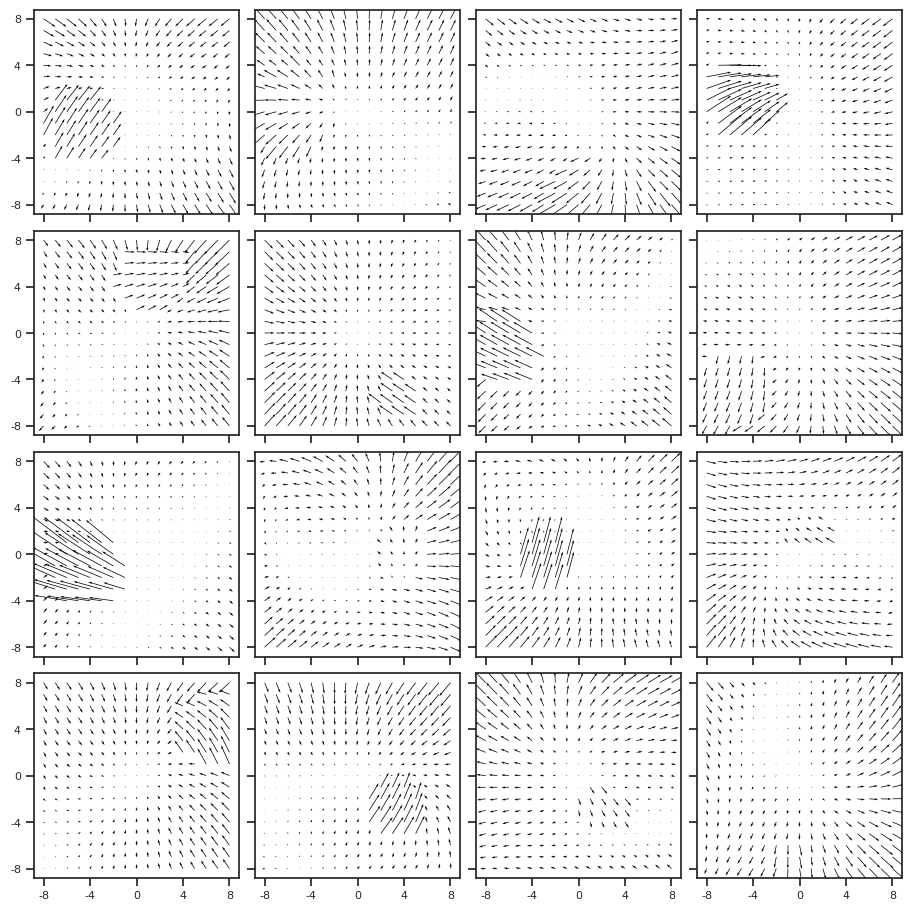

In [8]:
_ = show_opticflow(of.alpha_dot[accept])

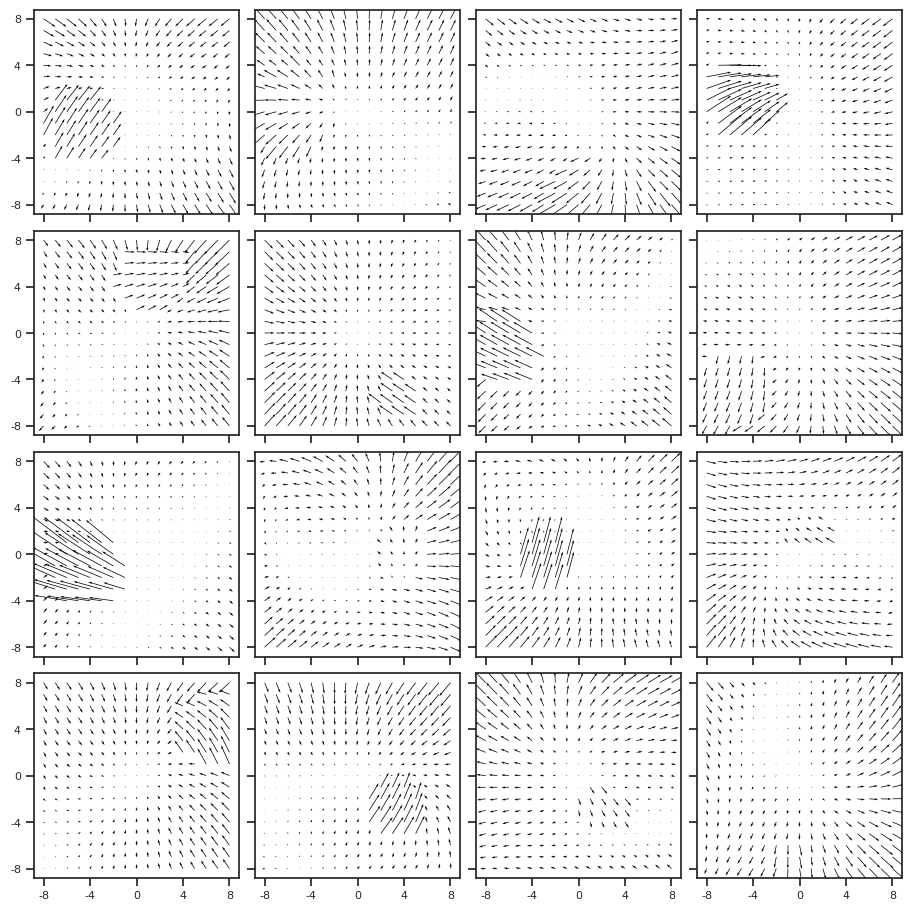

In [447]:
from analysis.opticflow import _replace_z

In [448]:
NUM = 7

In [449]:
def _do_it(fix, v_obj, alpha):
    of = ROFL(
        category='fixate',
        n=NUM,
        n_obj=1,
        **kws,
    )
    _ = of.compute_coords(fix)

    v_slf = np.repeat(np.array([0, 0, 1]).reshape(1, -1), NUM, 0)
    of.v_slf = v_slf

    v_obj = np.repeat(v_obj.reshape(1, -1), NUM, 0)

    theta, phi = radself2polar(
        a=alpha[:, 0],
        b=alpha[:, 1],
    )
    u = [np.ones(of.n), theta, phi]
    u = polar2cart(np.stack(u, axis=1))
    u = of.apply_rot(u, transpose=False)
    pos = _replace_z(u, np.ones(NUM) * 0.55)

    of.objects = {0: Obj(v_obj, pos, alpha, None, None)}

    _ = of.compute_flow()
    return of

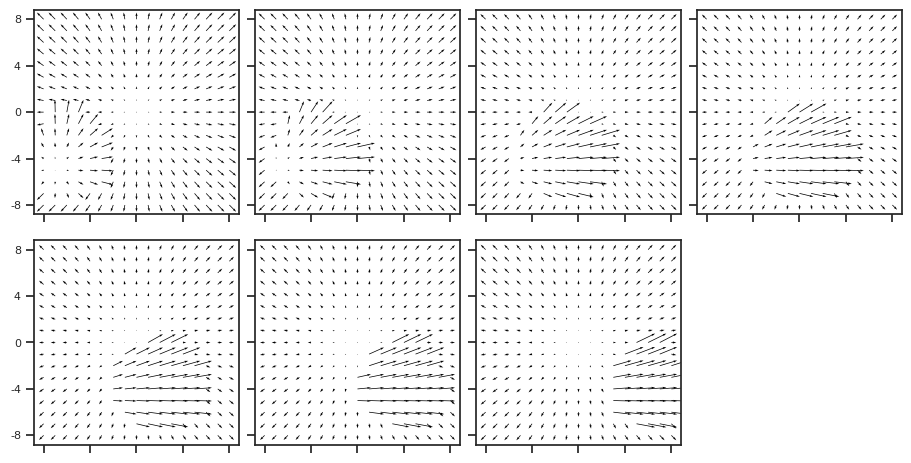

[2, 4, 6, 8, 10, 12, 14]

In [450]:
v_obj = np.array([0.8, 0.5, 0])

fix = np.array([0, 0])
fix = np.repeat(fix.reshape(1, -1), NUM, 0)

alpha = np.array([of.span[3], of.span[4]])
alpha = np.repeat(alpha.reshape(1, -1), NUM, 0)
inds = range(2, 2 + NUM * 2, 2)
alpha[:, 0] = [of.span[i] for i in inds]

of = _do_it(fix, v_obj, alpha)
_ = show_opticflow(of.alpha_dot)
print(list(inds))

In [451]:
row_1 = of.alpha_dot.copy()
tit_1 = [r"$F_x = 0, X_{obj} = $" + f"{e - 17 // 2}" for e in range(2, 2 + NUM * 2, 2)]

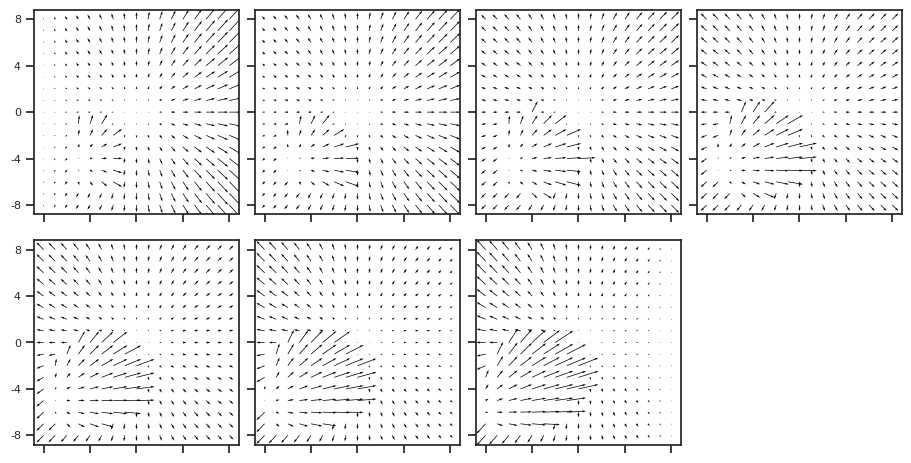

[-0.4        -0.26666667 -0.13333333  0.          0.13333333  0.26666667
  0.4       ]

In [452]:
fix = np.zeros((NUM, 2))
fix[:, 0] = np.linspace(-0.4, 0.4, NUM)

v_obj = np.array([0.8, 0.5, 0])
alpha = np.array([of.span[4], of.span[4]])
alpha = np.repeat(alpha.reshape(1, -1), NUM, 0)
# alpha[:, 0] = [of.span[i] for i in range(4, 14)]

of = _do_it(fix, v_obj, alpha)
_ = show_opticflow(of.alpha_dot)

print(np.linspace(-0.4, 0.4, NUM))

In [453]:
fix[:, 0]

array([-0.4       , -0.26666667, -0.13333333,  0.        ,  0.13333333,
        0.26666667,  0.4       ])

In [454]:
row_2 = of.alpha_dot.copy()
tit_2 = [r"$F_{x} = $" + f"{int(f*10)}, " + r"$X_{obj} = $" + '-4' for f in fix[:, 0]]

In [455]:
x = np.stack([row_1, row_2])
titles = np.empty((2, NUM), dtype=object)
titles[0] = tit_1
titles[1] = tit_2

x.shape, titles.shape

((2, 7, 17, 17, 2), (2, 7))

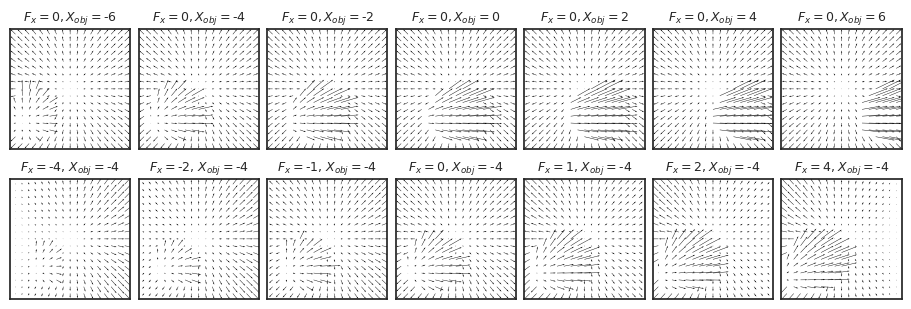

In [456]:
fig, axes = show_opticflow_row(x, titles=titles, title_fontsize=9, figsize=(9, 3), scale=12)

In [457]:
fig.savefig(pjoin(fig_base_dir, 'g_traversal.pdf'), **kws_fig)

## Examples

In [353]:
from analysis.opticflow import *

In [354]:
rows = np.zeros((3, 5, 17, 17, 2))

### fixate-1

In [355]:
%%time

of = ROFL(
    category='fixate',
    n=int(1.23e2),
    n_obj=1,
    **kws,
).compute_coords()
_ = of.compute_flow()
accept = of.filter(min_obj_size)
of.gamma = None

s, pcs, titles = _do_pca(of.alpha_dot[accept])

CPU times: user 331 ms, sys: 71 ms, total: 402 ms
Wall time: 171 ms


In [356]:
accept.sum()

110

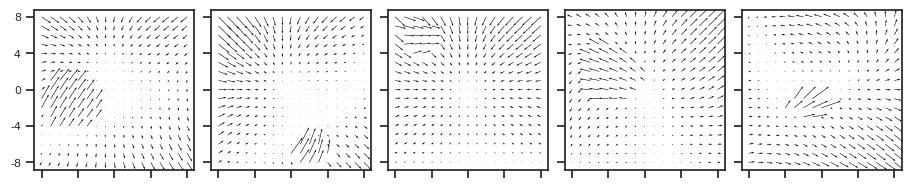

In [357]:
selected_1 = [0, 17, 22, 79, 40]
_ = show_opticflow(of.alpha_dot[accept][selected_1], 5)

In [358]:
rows[0] = of.alpha_dot[accept][selected_1]

### fixate-0

In [359]:
%%time

of = ROFL(
    category='fixate',
    n=int(1.23e2),
    n_obj=0,
    **kws,
).compute_coords()
_ = of.compute_flow()
accept = of.filter(min_obj_size)
of.gamma = None

s, pcs, titles = _do_pca(of.alpha_dot[accept])

CPU times: user 275 ms, sys: 0 ns, total: 275 ms
Wall time: 102 ms


In [360]:
accept.sum()

123

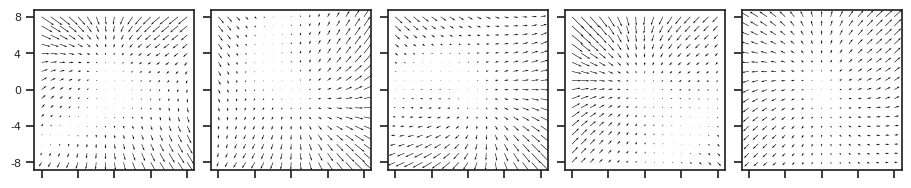

In [361]:
selected_2 = [0, 17, 22, 79, 40]
_ = show_opticflow(of.alpha_dot[accept][selected_2], 5)

In [362]:
rows[1] = of.alpha_dot[accept][selected_2]

### obj-1

In [363]:
%%time

of = ROFL(
    category='obj',
    n=int(1.23e2),
    n_obj=1,
    **kws,
).compute_coords()
_ = of.compute_flow()
accept = of.filter(min_obj_size)
of.gamma = None

s, pcs, titles = _do_pca(of.alpha_dot[accept])

CPU times: user 371 ms, sys: 2.38 ms, total: 373 ms
Wall time: 157 ms


In [364]:
accept.sum()

110

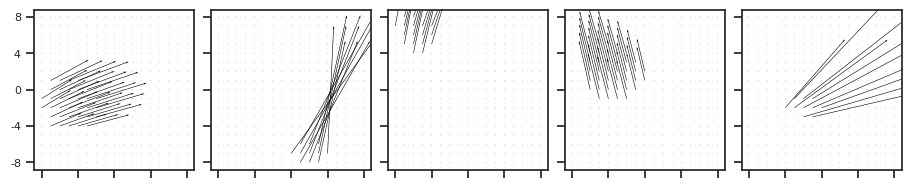

In [365]:
selected_3 = [0, 19, 12, 8, 40]
_ = show_opticflow(of.alpha_dot[accept][selected_1], 5)

In [366]:
rows[2] = of.alpha_dot[accept][selected_3]

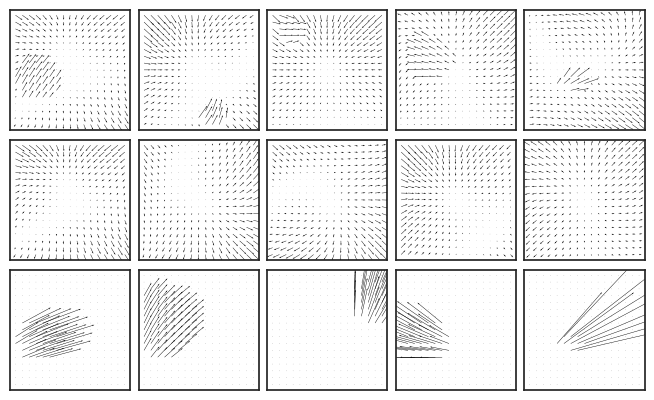

In [379]:
fig, axes = show_opticflow_row(rows, figsize=(9 / 7 * 5, 3.9))

In [380]:
fig.savefig(pjoin(fig_base_dir, 'rofl_eg.pdf'), **kws_fig)

## HF frame

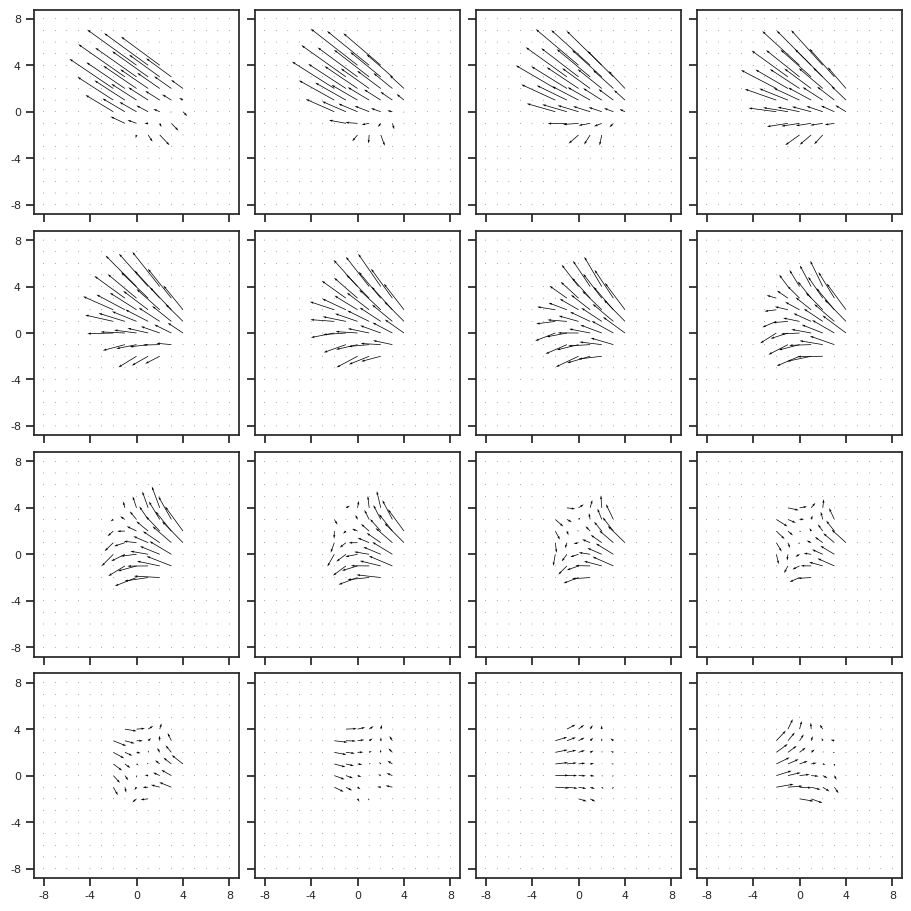

In [20]:
f = h5py.File('/home/hadi/Documents/MTMST/data/ALL_tres25.h5')
g = f['YUWEI']['clu090']
stim, spks, mask, stim_r, spks_r, good_r = load_ephys(g)
show_opticflow(stim[100:], scale=5);

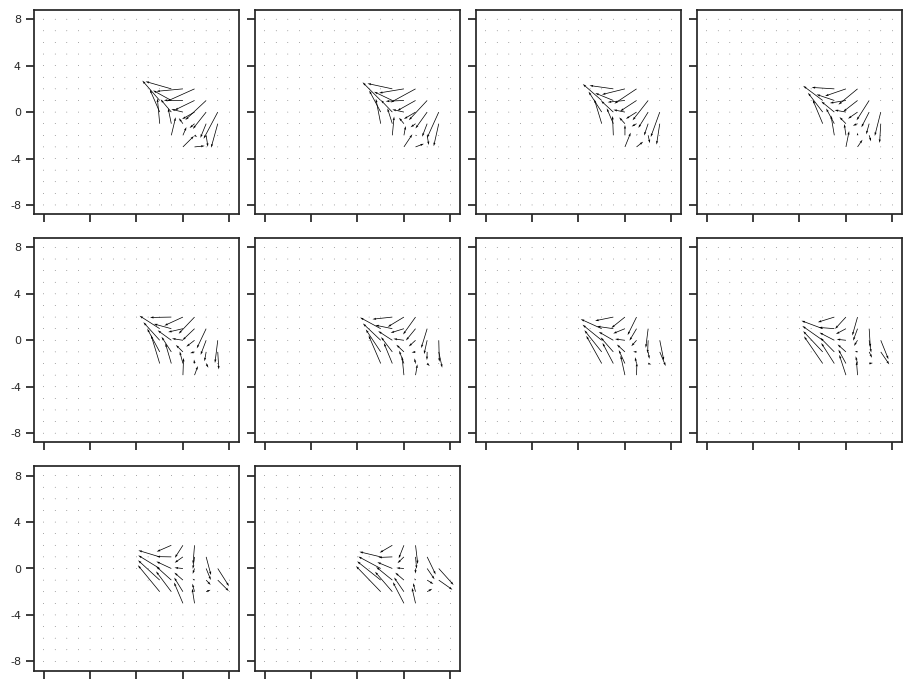

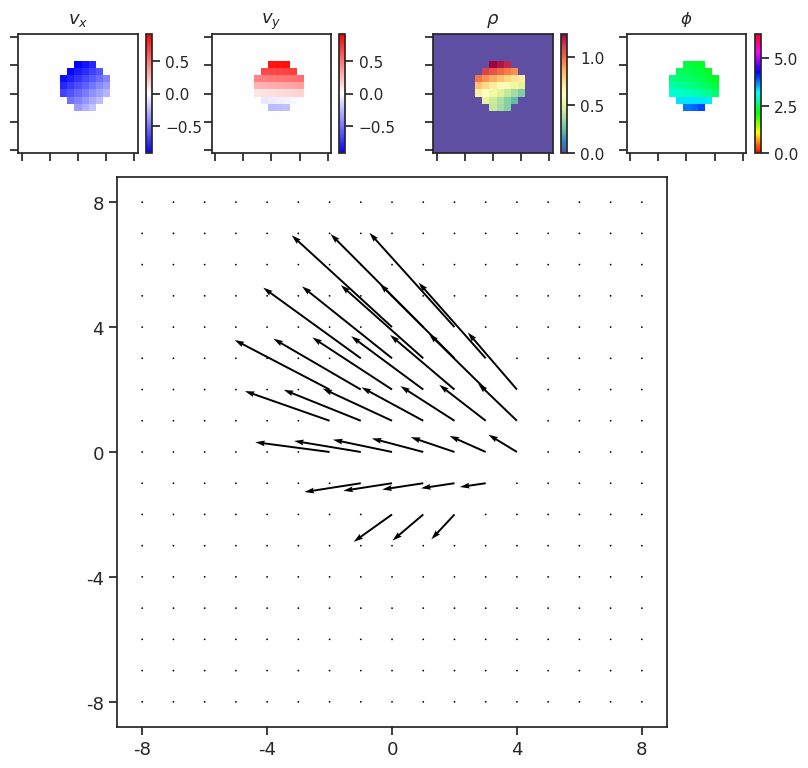

In [23]:
show_opticflow_full(stim[103], scale=5);

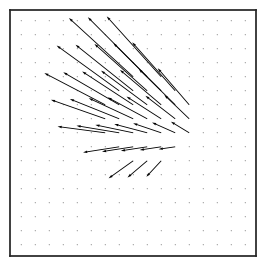

In [67]:
span = range(-8, 8 + 1)
ticks, ticklabels = make_ticks(span, 4)

fig, ax = create_figure(1, 1)
ax.quiver(
    span, span, stim[103][0], stim[103][1],
    # headaxislength=7,
    # headlength=,
    scale=3.5,
)
ax.set(
    xticks=ticks,
    yticks=ticks,
    xticklabels=ticklabels,
    yticklabels=ticklabels,
)
remove_ticks(ax, False)
ax_square(ax)
plt.show()

In [68]:
fig.savefig(pjoin(fig_base_dir, 'hf.pdf'), **kws_fig)

In [26]:
stim[103].shape

(2, 17, 17)

## Raster plot

In [73]:
g = f['YUWEI']['clu267']
stim, spks, mask, stim_r, spks_r, good_r = load_ephys(g)

In [78]:
x = spks_r[4]
x.shape

(43, 201)

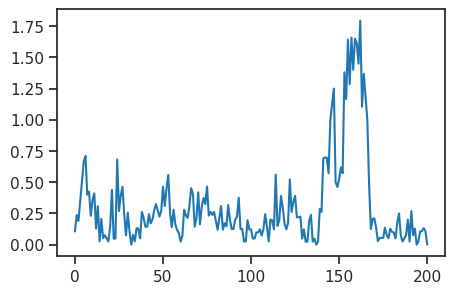

In [79]:
plt.plot(np.nanmean(x, 0));

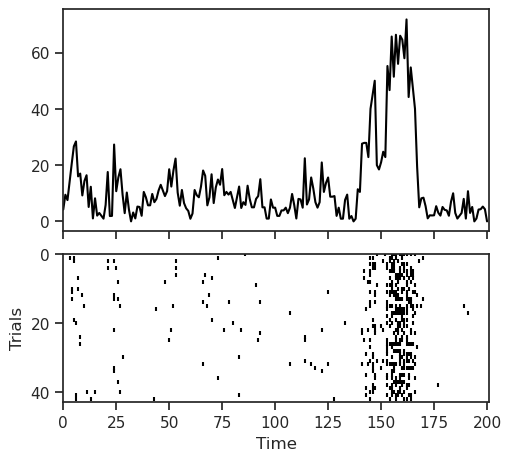

In [120]:
indices = np.argwhere(x > 1)

# Plot the raster plot
fig, axes = create_figure(2, 1, (5, 4.5), 'all', layout='constrained', height_ratios=[1.5, 1])
axes[0].plot(np.nanmean(x, 0) / 25e-3, color='k')
axes[1].scatter(indices[:, 1], indices[:, 0], marker='|', color='k', s=10, alpha=1)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Trials')
axes[1].set_xlim(0, x.shape[1])
axes[1].set_ylim(0, x.shape[0])
axes[1].invert_yaxis()
plt.show()

In [121]:
indices

array([[  0,  86],
       [  0, 148],
       [  0, 152],
       [  0, 155],
       [  0, 156],
       [  0, 157],
       [  0, 159],
       [  0, 160],
       [  0, 161],
       [  0, 162],
       [  0, 164],
       [  0, 166],
       [  1,   3],
       [  1,   5],
       [  1,  73],
       [  1, 145],
       [  1, 146],
       [  1, 154],
       [  1, 155],
       [  1, 157],
       [  1, 160],
       [  1, 170],
       [  2,   5],
       [  2,  21],
       [  2,  24],
       [  2,  53],
       [  2, 151],
       [  2, 154],
       [  2, 156],
       [  2, 158],
       [  2, 168],
       [  3, 145],
       [  3, 146],
       [  3, 147],
       [  3, 153],
       [  3, 155],
       [  3, 156],
       [  3, 160],
       [  3, 161],
       [  3, 162],
       [  4,  21],
       [  4,  25],
       [  4,  53],
       [  4, 146],
       [  4, 147],
       [  4, 153],
       [  4, 155],
       [  4, 156],
       [  4, 159],
       [  4, 161],
       [  4, 164],
       [  5, 142],
       [  5,

In [123]:
collections.Counter(x[np.isfinite(x)])

Counter({0.0: 6066, 1.0: 1679, 2.0: 329, 3.0: 61, 4.0: 8})